In [78]:
import sys
sys.path.append('..')
import ImpedanceSynthesiser as imps
import numpy as np
import matplotlib.pyplot as pl
%matplotlib notebook

reload(imps)

<module 'ImpedanceSynthesiser' from '../ImpedanceSynthesiser.pyc'>

In [79]:
world = imps.AcousticWorld()

l0 = 1.0
lb = .5

rad0 = .0075
rad_end = [.0075,.0035,.002,.001]

ducts = []

duct = imps.Duct(world=world,losses=True)
duct.set_termination(imps.PerfectOpenEnd())
duct.append_element(imps.StraightDuct(length=lb,radius=rad0))
ducts.append(duct)

for rad_e in rad_end:
    duct = imps.Duct(world=world,losses=True)
    duct.set_termination(imps.PerfectOpenEnd())
    duct.append_element(imps.StraightDuct(length=lb,radius=rad0))
    duct.append_element(imps.StraightDuct(length=l0-lb,radius=rad_e))
    ducts.append(duct)

duct = imps.Duct(world=world,losses=True)
duct.set_termination(imps.PerfectClosedEnd())
duct.append_element(imps.StraightDuct(length=lb,radius=rad0))
ducts.append(duct)

# append an extra 
rext = 0.05
lext = 0.01
for duct in ducts:
    duct.append_element(imps.StraightDuct(length=lext,radius=rext))


<IPython.core.display.Javascript object>


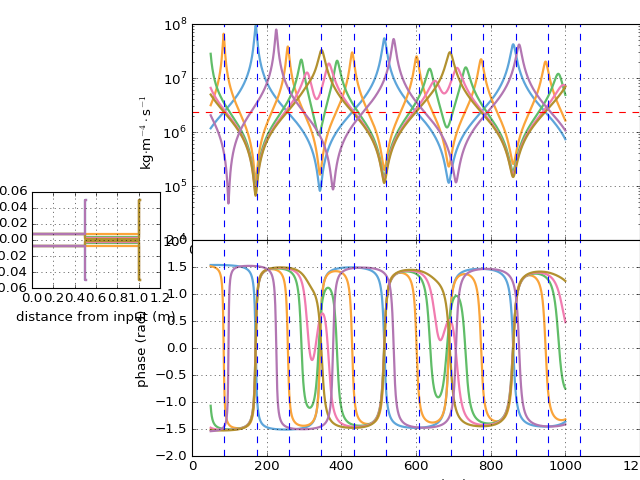

../ImpedanceSynthesiser.py:554: RuntimeWarning: divide by zero encountered in divide
  return (1.+r)/(1.-r)


In [80]:
fvec = np.linspace(10,1000,1000)

#fig,ax=pl.subplots(2,sharex=True)

ax = None
for duct in ducts:
    if ax is None:
        ax=duct.plot_report( fmax=max(fvec), npoints=2000)
    else:
        duct.plot_report(ax=ax, fmax=max(fvec), npoints=2000)
    
ax[1].axhline((np.abs(duct.elements[0].get_characteristic_impedance())),
              lw=1,ls='--',color='r')

f=0
c=duct.speed_of_sound
while f < max(fvec):
    f+=c/(4*l0)
    ax[1].axvline(f,ls='--',lw=1)
    ax[2].axvline(f,ls='--',lw=1)

<IPython.core.display.Javascript object>


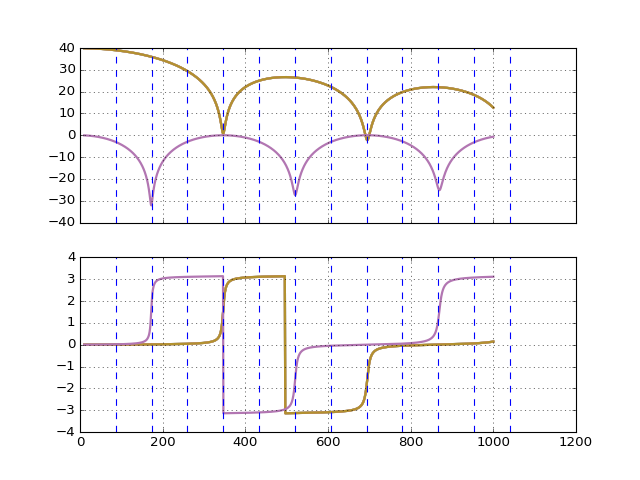

In [81]:
fvec = np.linspace(10,1000,1000)

fig,ax=pl.subplots(2,sharex=True)

pos= [0.005,lb-0.005]

for duct in ducts:
    tf = duct.pressure_transfer_func(fvec,from_pos=pos[0],to_pos=pos[1])
    ax[0].plot(fvec,20*np.log10(np.abs(tf)))
    ax[1].plot(fvec,(np.angle(tf)))
    
#ax[1].axhline((np.abs(duct.elements[0].get_characteristic_impedance())),
#              lw=1,ls='--',color='r')

f=0
c=duct.speed_of_sound
while f < max(fvec):
    f+=c/(4*l0)
    ax[0].axvline(f,ls='--',lw=1)
    ax[1].axvline(f,ls='--',lw=1)

In [82]:
np.matmul?

In [83]:
aa=np.arange(2*2*4).reshape(2,2,4)

In [84]:
np.dot(aa.swapaxes(0,2),aa.swapaxes(0,2)).swapaxes(0,2)

array([[[[ 32,  96],
         [ 36, 116],
         [ 40, 136],
         [ 44, 156]],

        [[ 48, 176],
         [ 52, 196],
         [ 56, 216],
         [ 60, 236]]],


       [[[ 40, 104],
         [ 46, 126],
         [ 52, 148],
         [ 58, 170]],

        [[ 64, 192],
         [ 70, 214],
         [ 76, 236],
         [ 82, 258]]],


       [[[ 48, 112],
         [ 56, 136],
         [ 64, 160],
         [ 72, 184]],

        [[ 80, 208],
         [ 88, 232],
         [ 96, 256],
         [104, 280]]],


       [[[ 56, 120],
         [ 66, 146],
         [ 76, 172],
         [ 86, 198]],

        [[ 96, 224],
         [106, 250],
         [116, 276],
         [126, 302]]]])

In [85]:
[np.matmul(aa[:,:,ii],aa[:,:,ii]) for ii in range(4)]

[array([[ 32,  48],
        [ 96, 176]]), array([[ 46,  70],
        [126, 214]]), array([[ 64,  96],
        [160, 256]]), array([[ 86, 126],
        [198, 302]])]

In [86]:
el=ducts[1].elements[0]
tm0=el.normalized_two_point_transfer_mx_at_freq(fvec)
el=ducts[1].elements[1]
tm1=el.normalized_two_point_transfer_mx_at_freq(fvec)

In [87]:
sw = [0,2]
np.matmul(tm0.swapaxes(*sw),tm1.swapaxes(*sw)).swapaxes(*sw)

array([[[ 0.98150080+0.00241193j,  0.97778477+0.00276048j,
          0.97373875+0.00312273j, ...,  0.80350045-0.07185126j,
          0.81431275-0.07016129j,  0.82486089-0.0684468j ],
        [-0.01233807-0.19187033j, -0.01285173-0.21002315j,
         -0.01333186-0.22807968j, ..., -0.09509276+0.60711799j,
         -0.09641945+0.59254879j, -0.09771608+0.57778708j]],

       [[-0.01233807-0.19187033j, -0.01285173-0.21002315j,
         -0.01333186-0.22807968j, ..., -0.09509276+0.60711799j,
         -0.09641945+0.59254879j, -0.09771608+0.57778708j],
        [ 0.98150080+0.00241193j,  0.97778477+0.00276048j,
          0.97373875+0.00312273j, ...,  0.80350045-0.07185126j,
          0.81431275-0.07016129j,  0.82486089-0.0684468j ]]])

In [88]:
z=el._chain_impedance_at_freq(freq=fvec,z_end=np.ones(len(fvec))*np.inf)
el._chain_impedance_at_freq(freq=fvec,z_end=z).shape

(1000,)

In [89]:
tm

array([[[ 0.99476181+0.00147791j,  0.99373568+0.00168412j,
          0.99262140+0.00189815j, ..., -0.97538330+0.03258648j,
         -0.97765965+0.0314751j , -0.97985611+0.03036004j],
        [-0.06540300-0.47396129j, -0.06815741-0.51772937j,
         -0.07077300-0.56133057j, ...,  0.57163526-1.17237534j,
          0.57324682-1.13184275j,  0.57481266-1.09121712j]],

       [[-0.00310188-0.02247864j, -0.00323251-0.02455443j,
         -0.00335656-0.02662232j, ...,  0.02711104-0.05560243j,
          0.02718747-0.05368009j,  0.02726173-0.05175333j],
        [ 0.99476181+0.00147791j,  0.99373568+0.00168412j,
          0.99262140+0.00189815j, ..., -0.97538330+0.03258648j,
         -0.97765965+0.0314751j , -0.97985611+0.03036004j]]])

In [90]:
ff=100
el.normalized_two_point_transfer_mx_at_freq(ff)

array([[ 0.60217211+0.0152343j , -0.01148728-0.79859426j],
       [-0.01148728-0.79859426j,  0.60217211+0.0152343j ]])

In [91]:
ffidx = np.argmin(np.abs(fvec-ff))
el.normalized_two_point_transfer_mx_at_freq(fvec)[:,:,ffidx]

array([[ 0.60085437+0.01526669j, -0.01147225-0.79958659j],
       [-0.01147225-0.79958659j,  0.60085437+0.01526669j]])

In [92]:
np.argmin(np.abs(fvec-ff))

91

In [93]:
el.get_propagation_coefficient(fvec)

array([  0.19305208-0.01257128j,   0.21158008-0.01314447j,
         0.23008296-0.01369227j,   0.24856377-0.01421777j,
         0.26702499-0.0147235j ,   0.28546867-0.01521153j,
         0.30389652-0.01568359j,   0.32230999-0.01614117j,
         0.34071032-0.01658551j,   0.35909859-0.01701771j,
         0.37747573-0.01743871j,   0.39584255-0.01784933j,
         0.41419979-0.01825031j,   0.43254809-0.01864229j,
         0.45088802-0.01902586j,   0.46922009-0.01940154j,
         0.48754477-0.01976979j,   0.50586248-0.02013104j,
         0.52417361-0.02048567j,   0.54247849-0.02083403j,
         0.56077746-0.02117645j,   0.57907079-0.02151321j,
         0.59735877-0.0218446j ,   0.61564163-0.02217085j,
         0.63391961-0.02249221j,   0.65219293-0.02280888j,
         0.67046177-0.02312106j,   0.68872633-0.02342894j,
         0.70698678-0.0237327j ,   0.72524327-0.02403249j,
         0.74349596-0.02432847j,   0.76174498-0.02462077j,
         0.77999048-0.02490953j,   0.79823258-0.02519488

In [94]:
[[el.get_length() for el in dd.elements] for dd in ducts]

[[0.5, 0.01],
 [0.5, 0.5, 0.01],
 [0.5, 0.5, 0.01],
 [0.5, 0.5, 0.01],
 [0.5, 0.5, 0.01],
 [0.5, 0.01]]